In [2]:
import sys

sys.path.append("../libs")


CONFIG = {
    "model_path": "../data/model/model_baseline.joblib",
    "features_path": "../data/model/baseline_features_list.json",
    "feature_dataset_database_file": "../data/feature_store.db",
}

In [3]:
import joblib

model = joblib.load(CONFIG["model_path"])

In [4]:
import json

with open(CONFIG["features_path"], 'r') as f:
    features = json.load(f)


In [4]:
from feature_dataset import FeatureDataset
import pandas as pd
fs = FeatureDataset(CONFIG['feature_dataset_database_file'])

df_train: pd.DataFrame = fs.get_feature_dataset(name="training", version=1)

In [5]:
df_train['target'].describe()

count    823495.000000
mean          0.179438
std           0.383719
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: target, dtype: float64

In [6]:
df_train['time_of_banking_days'] = (df_train['issue_d'] - df_train['earliest_cr_line']).dt.days
df_train['time_of_banking_months'] = (df_train['issue_d'].dt.year - df_train['earliest_cr_line'].dt.year) * 12 + (df_train['issue_d'].dt.month - df_train['earliest_cr_line'].dt.month)

In [7]:
df_train['emp_length'] = df_train['emp_length'].str.replace(' years', '').str.replace(' year', '').str.replace('< 1', '0').str.replace('+', '').astype(float)

In [8]:
cat_features = [
    "emp_length",
    "home_ownership",
    "verification_status",
    "purpose",
    "addr_state",
    "application_type",
]
df_train[cat_features] = df_train[cat_features].astype(str).fillna('missing')

In [9]:
df_train.head()

,id,loan_amnt,funded_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,default,time_of_banking_days,time_of_banking_months,target
0,87023,7500,7500,36,255.375,0.0,OWN,22000.0,Not Verified,2007-06-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,1339,44,0.0
1,92533,5000,5000,36,164.250,0.0,OWN,80000.0,Not Verified,2007-07-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,4017,132,0.0
2,93277,3000,3000,36,95.000,0.0,MORTGAGE,25000.0,Not Verified,2007-07-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,2494,82,0.0
3,93061,5000,5000,36,155.375,8.0,MORTGAGE,120000.0,Not Verified,2007-07-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,3560,117,0.0
4,92676,5000,5000,36,156.875,0.0,MORTGAGE,180000.0,Not Verified,2007-07-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,4047,133,0.0


In [10]:
# Drop rows with missing target values
df_train = df_train.dropna(subset=["target"])

In [11]:
df_train.head()

,id,loan_amnt,funded_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,default,time_of_banking_days,time_of_banking_months,target
0,87023,7500,7500,36,255.375,0.0,OWN,22000.0,Not Verified,2007-06-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,1339,44,0.0
1,92533,5000,5000,36,164.250,0.0,OWN,80000.0,Not Verified,2007-07-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,4017,132,0.0
2,93277,3000,3000,36,95.000,0.0,MORTGAGE,25000.0,Not Verified,2007-07-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,2494,82,0.0
3,93061,5000,5000,36,155.375,8.0,MORTGAGE,120000.0,Not Verified,2007-07-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,3560,117,0.0
4,92676,5000,5000,36,156.875,0.0,MORTGAGE,180000.0,Not Verified,2007-07-01,...,-1.0,-1,-1,-1.0,-1.0,-1.0,0.0,4047,133,0.0


Baseline Model

In [12]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import shap
from sklearn.metrics import log_loss, average_precision_score

X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train["target"], test_size=0.2, random_state=42)

#X_train[cat_features] = X_train[cat_features].astype(str).fillna('missing')

#X_test[cat_features] = X_test[cat_features].astype(str).fillna('missing')

# Identify categorical features
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Convert categorical features to string (just in case)
for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Initialize and train CatBoost classifier
model = CatBoostClassifier(iterations = 1000,
                            auto_class_weights = "Balanced",
                            eval_metric = "PRAUC:use_weights=false",
                            cat_features = cat_features,
                            verbose = True,
                            random_seed = 42,
                            max_depth = 8,
                            colsample_bylevel = 0.8,
                            subsample = 0.7,
                            learning_rate = 0.02,
                            early_stopping_rounds = 100)
model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate model
logloss = log_loss(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print(f"Log Loss: {logloss:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

/Users/marcos.mota/projects/personal/lending_club/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0:	learn: 0.6825798	total: 231ms	remaining: 3m 50s
1:	learn: 0.6753294	total: 390ms	remaining: 3m 14s
2:	learn: 0.6879107	total: 577ms	remaining: 3m 11s
3:	learn: 0.6882074	total: 736ms	remaining: 3m 3s
4:	learn: 0.6896500	total: 891ms	remaining: 2m 57s
5:	learn: 0.6902331	total: 1.03s	remaining: 2m 51s
6:	learn: 0.6906387	total: 1.2s	remaining: 2m 50s
7:	learn: 0.6912094	total: 1.38s	remaining: 2m 51s
8:	learn: 0.6903543	total: 1.53s	remaining: 2m 48s
9:	learn: 0.6920852	total: 1.71s	remaining: 2m 49s
10:	learn: 0.6927793	total: 1.86s	remaining: 2m 47s
11:	learn: 0.6924460	total: 2.04s	remaining: 2m 48s
12:	learn: 0.6933847	total: 2.23s	remaining: 2m 49s
13:	learn: 0.6940937	total: 2.41s	remaining: 2m 49s
14:	learn: 0.6948014	total: 2.59s	remaining: 2m 50s
15:	learn: 0.6943580	total: 2.78s	remaining: 2m 50s
16:	learn: 0.6945998	total: 2.97s	remaining: 2m 51s
17:	learn: 0.6946357	total: 3.16s	remaining: 2m 52s
18:	learn: 0.6943404	total: 3.35s	remaining: 2m 52s
19:	learn: 0.6942537	tot

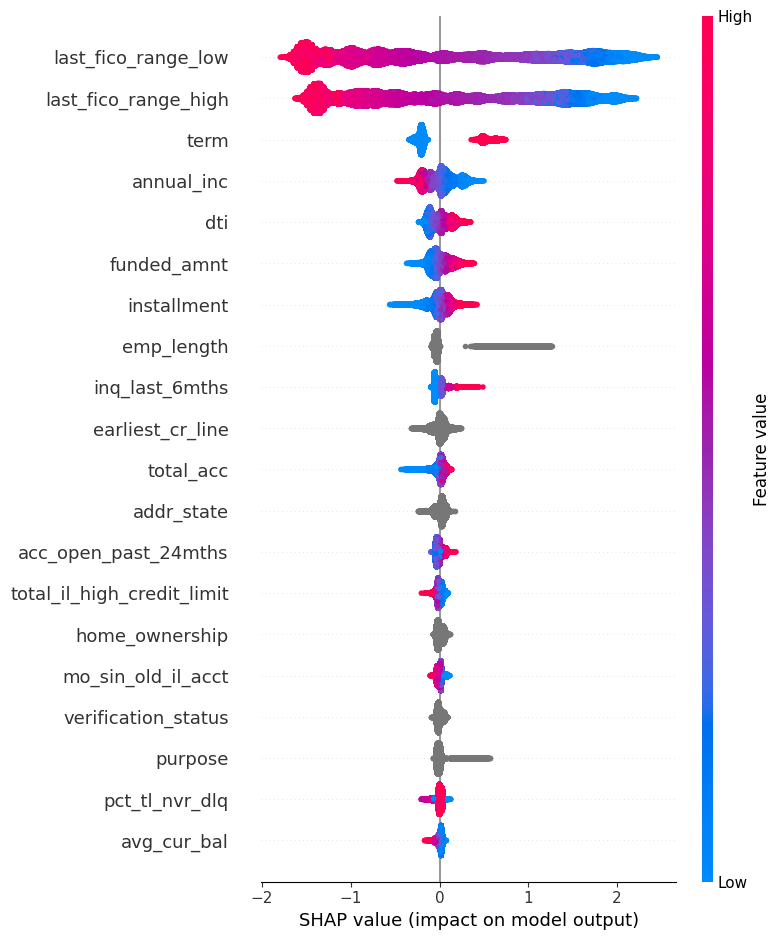

In [13]:
# SHAP Analysis
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

Hyperparameter Tuning

Tuning by Log Loss

In [14]:
import optuna

# Types for tuning hipeparameters: https://www.linkedin.com/posts/timurbikmukhametov_9-practical-tips-for-tuning-gradient-boosting-activity-7285985903984955392-IRHR?utm_source=share&utm_medium=member_desktop
def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [300, 500, 750, 1000,1500]),
        'max_depth': trial.suggest_int('depth', 4, 12),
        'early_stopping_rounds': 50,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10, log=True),  # Regularization
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),  # Regularization
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),  # Reducing overfitting
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['None', 'Balanced', 'SqrtBalanced']),
        'verbose': 0,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True)
    }

    # Identify categorical features
    cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

    # Convert categorical features to string (just in case)
    for col in cat_features:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)

    model = CatBoostClassifier(**params)
    model.fit(
    X_train, y_train,
    cat_features=cat_features,  # ✅ Make sure this list is correct
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
    )

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate model
    logloss = log_loss(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    # Store them in user_attrs
    trial.set_user_attr("log_loss", logloss)
    trial.set_user_attr("pr_auc", pr_auc)

    #return logloss + (1 - pr_auc) # Minimize logloss while maximizing PR-AUC
    return logloss

study = optuna.create_study(direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))

print('Tuning the model...')
study.optimize(objective, timeout=3600, n_trials=None)

best_params = study.best_params
print(f'Best parameters: {best_params}')

[I 2025-02-12 14:16:25,127] A new study created in memory with name: no-name-95755f3e-eb1f-4218-8315-9b3bc2f28f64


Tuning the model...


[I 2025-02-12 14:16:50,843] Trial 0 finished with value: 0.3747793584340322 and parameters: {'iterations': 300, 'depth': 4, 'l2_leaf_reg': 0.13206941383628484, 'bagging_temperature': 0.3444879621052125, 'random_strength': 0.21745729986965334, 'colsample_bylevel': 0.8747327281790702, 'subsample': 0.5923719380842167, 'auto_class_weights': 'Balanced', 'learning_rate': 0.005224709259320977}. Best is trial 0 with value: 0.3747793584340322.
[I 2025-02-12 14:18:05,415] Trial 1 finished with value: 0.27971946153549765 and parameters: {'iterations': 300, 'depth': 10, 'l2_leaf_reg': 0.5716892742669437, 'bagging_temperature': 0.047498029787753526, 'random_strength': 0.3957494162063199, 'colsample_bylevel': 0.8569301200001287, 'subsample': 0.8160623469160332, 'auto_class_weights': 'SqrtBalanced', 'learning_rate': 0.018364992337319155}. Best is trial 1 with value: 0.27971946153549765.
[I 2025-02-12 14:18:34,374] Trial 2 finished with value: 0.2780943631723402 and parameters: {'iterations': 300, 'de

Best parameters: {'iterations': 500, 'depth': 8, 'l2_leaf_reg': 9.834300354524748, 'bagging_temperature': 0.24889513031756605, 'random_strength': 3.567226558555074e-06, 'colsample_bylevel': 0.5435485477518852, 'subsample': 0.8879383386679125, 'auto_class_weights': 'None', 'learning_rate': 0.0823078661901285}


In [15]:
import json

print('Saving the best parameters to a JSON file...\n ', json.dumps(best_params, indent=4))

Saving the best parameters to a JSON file...
  {
    "iterations": 500,
    "depth": 8,
    "l2_leaf_reg": 9.834300354524748,
    "bagging_temperature": 0.24889513031756605,
    "random_strength": 3.567226558555074e-06,
    "colsample_bylevel": 0.5435485477518852,
    "subsample": 0.8879383386679125,
    "auto_class_weights": "None",
    "learning_rate": 0.0823078661901285
}


In [16]:
df_results = pd.DataFrame(
    [
        {
            "trial": t.number,
            "value": t.value,
            "log_loss": t.user_attrs.get("log_loss"),
            "pr_auc": t.user_attrs.get("pr_auc"),
            **t.params,
        }
        for t in study.trials
    ]
)

print(df_results[["trial", "value", "log_loss", "pr_auc"]])

    trial     value  log_loss    pr_auc
0       0  0.374779  0.374779  0.697745
1       1  0.279719  0.279719  0.718614
2       2  0.278094  0.278094  0.721903
3       3  0.277581  0.277581  0.722783
4       4  0.259324  0.259324  0.711816
5       5  0.280989  0.280989  0.716889
6       6  0.272813  0.272813  0.699907
7       7  0.328634  0.328634  0.695753
8       8  0.297797  0.297797  0.709396
9       9  0.279075  0.279075  0.718363
10     10  0.252167  0.252167  0.724987
11     11  0.252709  0.252709  0.723438
12     12  0.252671  0.252671  0.723671
13     13  0.252022  0.252022  0.725683
14     14  0.252107  0.252107  0.725297
15     15  0.349039  0.349039  0.722507
16     16  0.252365  0.252365  0.724901
17     17  0.252691  0.252691  0.723456
18     18  0.252223  0.252223  0.724878
19     19  0.354935  0.354935  0.719761
20     20  0.253257  0.253257  0.722741
21     21  0.252181  0.252181  0.724693
22     22  0.252107  0.252107  0.725479
23     23  0.253365  0.253365  0.722872


Tuning by Log Loss + (1 - PRAUC)

In [ ]:
# Types for tuning hipeparameters: https://www.linkedin.com/posts/timurbikmukhametov_9-practical-tips-for-tuning-gradient-boosting-activity-7285985903984955392-IRHR?utm_source=share&utm_medium=member_desktop
def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [300, 500, 750, 1000,1500]),
        'max_depth': trial.suggest_int('depth', 4, 12),
        'early_stopping_rounds': 50,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10, log=True),  # Regularization
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),  # Regularization
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),  # Reducing overfitting
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['None', 'Balanced', 'SqrtBalanced']),
        'verbose': 0,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True)
    }

    # Identify categorical features
    cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

    # Convert categorical features to string (just in case)
    for col in cat_features:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)

    model = CatBoostClassifier(**params)
    model.fit(
    X_train, y_train,
    cat_features=cat_features,  # ✅ Make sure this list is correct
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
    )

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate model
    logloss = log_loss(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    # Store them in user_attrs
    trial.set_user_attr("log_loss", logloss)
    trial.set_user_attr("pr_auc", pr_auc)

    return logloss + (1 - pr_auc) # Minimize logloss while maximizing PR-AUC

study = optuna.create_study(direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))

print('Tuning the model...')
study.optimize(objective, timeout=3600, n_trials=None)

best_params = study.best_params
print(f'Best parameters: {best_params}')

[I 2025-02-12 15:16:51,301] A new study created in memory with name: no-name-631ca6af-078a-4d4f-b90b-86b8cece4eb3


Tuning the model...


[I 2025-02-12 15:18:13,805] Trial 0 finished with value: 0.5806830881063426 and parameters: {'iterations': 300, 'depth': 12, 'l2_leaf_reg': 0.05354331134306332, 'bagging_temperature': 0.500919092199032, 'random_strength': 3.867734576032243e-09, 'colsample_bylevel': 0.646130808328353, 'subsample': 0.7842258343055402, 'auto_class_weights': 'SqrtBalanced', 'learning_rate': 0.0054298577620211595}. Best is trial 0 with value: 0.5806830881063426.
[I 2025-02-12 15:25:55,013] Trial 1 finished with value: 0.5716660975089767 and parameters: {'iterations': 1500, 'depth': 12, 'l2_leaf_reg': 0.05148598120619836, 'bagging_temperature': 0.598802585677346, 'random_strength': 2.354327857760119e-08, 'colsample_bylevel': 0.9255774030865609, 'subsample': 0.5983356249347818, 'auto_class_weights': 'SqrtBalanced', 'learning_rate': 0.0014145243609456825}. Best is trial 1 with value: 0.5716660975089767.
[I 2025-02-12 15:26:28,508] Trial 2 finished with value: 0.6353493193170096 and parameters: {'iterations': 1

Best parameters: {'iterations': 750, 'depth': 8, 'l2_leaf_reg': 4.696566257752305, 'bagging_temperature': 0.5256775947325836, 'random_strength': 0.08414203729823212, 'colsample_bylevel': 0.896588107319767, 'subsample': 0.9947381979952601, 'auto_class_weights': 'None', 'learning_rate': 0.05970197859664135}


In [18]:
print('Saving the best parameters to a JSON file...\n ', json.dumps(best_params, indent=4))

Saving the best parameters to a JSON file...
  {
    "iterations": 750,
    "depth": 8,
    "l2_leaf_reg": 4.696566257752305,
    "bagging_temperature": 0.5256775947325836,
    "random_strength": 0.08414203729823212,
    "colsample_bylevel": 0.896588107319767,
    "subsample": 0.9947381979952601,
    "auto_class_weights": "None",
    "learning_rate": 0.05970197859664135
}


In [19]:
df_results = pd.DataFrame(
    [
        {
            "trial": t.number,
            "value": t.value,
            "log_loss": t.user_attrs.get("log_loss"),
            "pr_auc": t.user_attrs.get("pr_auc"),
            **t.params,
        }
        for t in study.trials
    ]
)

print(df_results[["trial", "value", "log_loss", "pr_auc"]])

    trial     value  log_loss    pr_auc
0       0  0.580683  0.292782  0.712099
1       1  0.571666  0.285696  0.714030
2       2  0.635349  0.351751  0.716402
3       3  0.556415  0.278204  0.721789
4       4  0.526071  0.251994  0.725923
5       5  0.557270  0.263711  0.706441
6       6  0.651540  0.361386  0.709847
7       7  0.555888  0.277992  0.722104
8       8  0.539589  0.256310  0.716722
9       9  0.557311  0.278584  0.721274
10     10  0.536327  0.254806  0.718480
11     11  0.537763  0.255053  0.717290
12     12  0.535214  0.254419  0.719205
13     13  0.527931  0.252348  0.724417
14     14  0.527701  0.252382  0.724681
15     15  0.544931  0.258804  0.713873
16     16  0.528928  0.252781  0.723852
17     17  0.629958  0.350900  0.720942
18     18  0.528459  0.252602  0.724143
19     19  0.531215  0.253245  0.722030
20     20  0.638817  0.356572  0.717755
21     21  0.528642  0.252646  0.724004
22     22  0.525696  0.251832  0.726136
23     23  0.526679  0.251944  0.725265


Model tuned to minimize Log Loss

In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import shap
from sklearn.metrics import log_loss, average_precision_score

X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train["target"], test_size=0.2, random_state=42)

#X_train[cat_features] = X_train[cat_features].astype(str).fillna('missing')

#X_test[cat_features] = X_test[cat_features].astype(str).fillna('missing')

# Identify categorical features
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Convert categorical features to string (just in case)
for col in cat_features:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Initialize and train CatBoost classifier
model = CatBoostClassifier( iterations = 1500,
                            auto_class_weights = "None",
                            eval_metric = "Logloss",
                            cat_features = cat_features,
                            verbose = 0,
                            random_seed = 42,
                            max_depth = 10,
                            colsample_bylevel = 0.9985968073271833,
                            subsample = 0.838505857908814,
                            learning_rate = 0.035308682185235266,
                            early_stopping_rounds = 100,
                            l2_leaf_reg= 7.519867011663144,
                            bagging_temperature= 0.06522479072002263,
                            random_strength= 1.0373034782420635e-06)
model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate model
logloss = log_loss(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print(f"Log Loss: {logloss:.4f}")
print(f"PR AUC: {pr_auc:.4f}")


Log Loss: 0.2516
PR AUC: 0.7264
